In [1]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from glob import glob
import json, codecs

## 1-Read Data

In [2]:
train_path = "data/Training/"
test_path = "data/Test/"

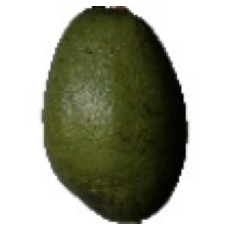

In [3]:
img = load_img(train_path + "Avocado/0_100.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
x = img_to_array(img) # jpg to array
x.shape # 100x100 and 3=RGB

(100, 100, 3)

In [6]:
numberOfClass = len(glob(train_path+"/*"))
numberOfClass # There are 131 kinds of fruits (class)

131